### Set Up

In [1]:
# import packages
import os 
from tqdm import tqdm
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import re
import torch
from transformers import BertTokenizer
import clip
import nltk
import string

from urllib import request
import urllib.request
import urllib.error
from concurrent.futures import ThreadPoolExecutor, as_completed

from PIL import Image
from torchvision import transforms

In [47]:
# load data
fakeddit = pd.read_csv('../data/multimodal_train.tsv', sep='\t')

In [21]:
len(fakeddit)

564000

In [48]:
# do 10% stratified subsampling of dataset
RANDOM_STATE = 42
df, df_backup = train_test_split(
    fakeddit,
    test_size=0.90,
    shuffle=True,
    stratify=fakeddit['3_way_label'],
    random_state=RANDOM_STATE
)

In [49]:
df.reset_index(drop=True, inplace=True)
len(df)

56400

### Data Exploration

In [24]:
df.head(5)

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,coryscalculator,yay for recycling,1.367963e+09,i.imgur.com,True,1dw0fk,https://external-preview.redd.it/SVpV2wF-Wzh4R...,NaN,0.0,6,pareidolia,Yay for recycling,0.81,0,2,2
1,50missioncap,yep theyre,1.462805e+09,NaN,True,d2ymcmj,http://i.imgur.com/oNLeh6A.jpg,4iif8d,NaN,2,psbattle_artwork,"Yep. They're 8""",NaN,0,2,4
2,yismeicha,casper the friendly coat,1.449010e+09,i.imgur.com,True,3v2a8d,https://external-preview.redd.it/annFO2AfFN7eV...,NaN,14.0,444,pareidolia,Casper the Friendly Coat,0.92,0,2,2
3,Touchstone033,bavarian bert,1.514869e+09,NaN,True,ds2gavx,https://i.imgur.com/hSEJSDX.jpg,7n8kwm,NaN,1,psbattle_artwork,colorized Bavarian Bert.,NaN,0,2,4
4,dannylenwinn,georgia governor signs restrictive heartbeat a...,1.557258e+09,apnews.com,True,blv8d1,https://external-preview.redd.it/E_n9-eE_xMhvO...,NaN,2.0,9,usnews,Georgia governor signs restrictive 'heartbeat'...,0.77,1,0,0


In [18]:
df.describe()

,3_way_label
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [50]:
df_check = df.drop(['author', 'clean_title', 'title',
                    'created_utc', 'linked_submission_id', 'id', 'image_url',
                    'num_comments', 'score', 'upvote_ratio'],
                    axis=1, inplace=False)
for col in df_check:
    print("Name of column:", col, "\nValues:", df_check[col].unique(), "\n")

Name of column: domain 
Values: ['i.imgur.com' nan 'apnews.com' ... 'eff.org' 'buzzednation.com'
 'thepunditpress.com'] 

Name of column: hasImage 
Values: [ True] 

Name of column: subreddit 
Values: ['pareidolia' 'psbattle_artwork' 'usnews' 'photoshopbattles'
 'mildlyinteresting' 'confusing_perspective' 'propagandaposters'
 'theonion' 'fakehistoryporn' 'upliftingnews' 'nottheonion'
 'fakealbumcovers' 'misleadingthumbnails' 'usanews' 'subredditsimulator'
 'savedyouaclick' 'waterfordwhispersnews' 'neutralnews' 'satire' 'pic'
 'subsimulatorgpt2' 'fakefacts'] 

Name of column: 2_way_label 
Values: [0 1] 

Name of column: 3_way_label 
Values: [2 0 1] 

Name of column: 6_way_label 
Values: [2 4 0 5 1 3] 



Since we will be using 3-way classification for our project, we will drop the label columns for 2-way and 6-way classification. 

In [51]:
df.drop(['2_way_label', '6_way_label'], axis=1, inplace=True)
df.head(5)

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,3_way_label
0,coryscalculator,yay for recycling,1.367963e+09,i.imgur.com,True,1dw0fk,https://external-preview.redd.it/SVpV2wF-Wzh4R...,NaN,0.0,6,pareidolia,Yay for recycling,0.81,2
1,50missioncap,yep theyre,1.462805e+09,NaN,True,d2ymcmj,http://i.imgur.com/oNLeh6A.jpg,4iif8d,NaN,2,psbattle_artwork,"Yep. They're 8""",NaN,2
2,yismeicha,casper the friendly coat,1.449010e+09,i.imgur.com,True,3v2a8d,https://external-preview.redd.it/annFO2AfFN7eV...,NaN,14.0,444,pareidolia,Casper the Friendly Coat,0.92,2
3,Touchstone033,bavarian bert,1.514869e+09,NaN,True,ds2gavx,https://i.imgur.com/hSEJSDX.jpg,7n8kwm,NaN,1,psbattle_artwork,colorized Bavarian Bert.,NaN,2
4,dannylenwinn,georgia governor signs restrictive heartbeat a...,1.557258e+09,apnews.com,True,blv8d1,https://external-preview.redd.it/E_n9-eE_xMhvO...,NaN,2.0,9,usnews,Georgia governor signs restrictive 'heartbeat'...,0.77,0


**3-way classification**
* 0: True (completely true sample)

* 1: Misleading (fake sample with some true text)

* 2: Fake (fake sample with fake text)

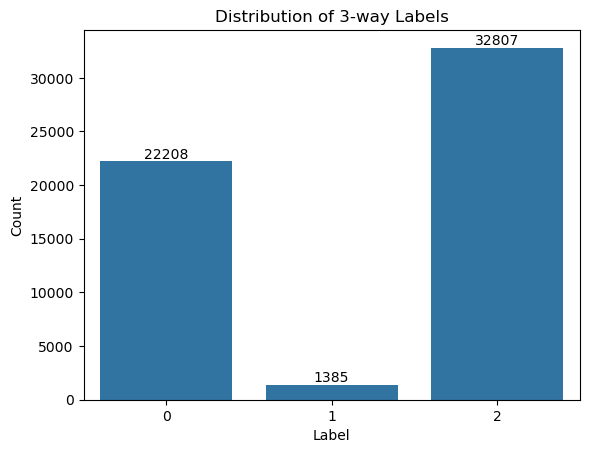

In [52]:
# check class balance
counts = df['3_way_label'].value_counts().sort_index()

ax = sns.barplot(x=counts.index, y=counts.values)
for i, count in enumerate(counts.values):
    ax.text(i, count + 250, str(count), ha='center')
plt.title("Distribution of 3-way Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Data Preprocessing

In [41]:
# make a copy of df
df_clean = df.copy()

#### Image Preprocessing

In [53]:
# replace NaN values with empty strings
df_clean = df_clean.replace(np.nan, '', regex=True)
df_clean.fillna('', inplace=True)

# download images
def download_image(row, save_dir='../data/images/'):
    image_url = row['image_url']
    image_id = row['id']
    path = save_dir + image_id + '.jpg'

    if row['hasImage'] and image_url not in ['', 'nan']:
        try:
            with urllib.request.urlopen(image_url, timeout=10) as response:
                with open(path, 'wb') as f:
                    f.write(response.read())
            return None         # success
        except Exception as e:
            return row.name     # index of rows with invalid image_url
    return None

# download in parallel
drop_indices = []
with ThreadPoolExecutor(max_workers=16) as executor:  
    futures = {executor.submit(download_image, row): idx for idx, row in df_clean.iterrows()}

    for i, future in enumerate(tqdm(as_completed(futures), total=len(futures))):
        idx = future.result()
        if idx is not None:
            drop_indices.append(idx)

df_clean.drop(index=drop_indices, inplace=True)
df_clean.reset_index(drop=True, inplace=True)

print("Downloaded all images.")

100%|██████████| 56400/56400 [35:31<00:00, 26.46it/s]    

Downloaded all images.


In [56]:
# from inspection, some image files are empty
# drop rows with empty/corrupted image files
def drop_empty_images(df, directory='../data/images/'):

    empty_files = []
    drop_indices = []

    for idx, row in df.iterrows():
        image_path = directory + row['id'] + '.jpg'
        try:
            with Image.open(image_path) as img:
                img.verify()
        except:
            empty_files.append(image_path)
            drop_indices.append(idx)
            # delete empty file
            if os.path.exists(image_path):
                os.remove(image_path)
        
    df.drop(index=drop_indices, axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return empty_files

empty_images = drop_empty_images(df_clean)
if empty_images:
    print(f"Found {len(empty_images)} empty images.")
else:
    print('All images are valid.')

All images are valid.


(535, 320, 3)


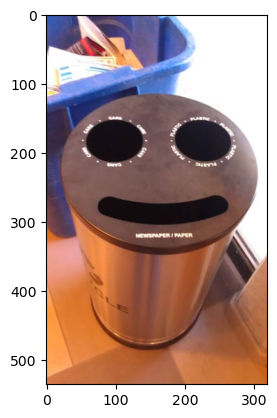

(426, 320, 3)


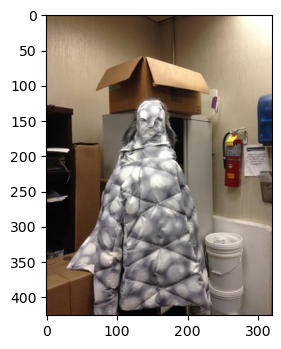

(257, 320, 3)


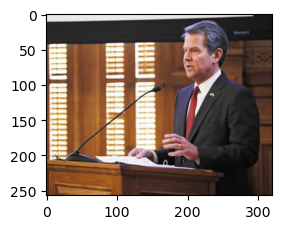

(399, 320, 3)


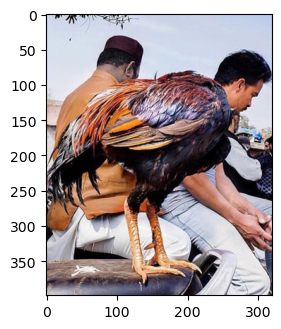

(240, 320, 3)


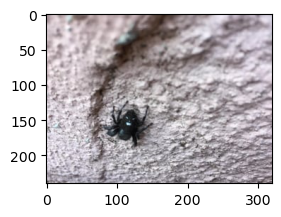

In [55]:
# test plot images
for i in range(5):
    path = '../data/images/' + df_clean['id'][i] + '.jpg'
    im = np.array(Image.open(path))

    print(im.shape)
    ax = plt.subplot(121)
    ax.imshow(im)
    plt.show()

In [14]:
# resizing pipeline
resize = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])

save_dir = '../data/images/'

# resize images to (224, 224, 3)
def resize_image(image_id):
    path = save_dir + image_id + '.jpg'
    try:
        with Image.open(path).convert("RGB") as img:
            resized = resize(img)
            resized.save(path)
        return None
    except Exception as e:
        return image_id  # return failed image id

# parallel resizing
image_ids = df_clean['id'].tolist()
failed = []

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(resize_image, img_id) for img_id in image_ids]

    for future in tqdm(as_completed(futures), total=len(futures)):
        result = future.result()
        if result is not None:
            failed.append(result)

print(f"Resized all images. Failed: {len(failed)}")

  0%|          | 50/37726 [00:00<01:15, 498.56it/s]c:\Users\Isabella\Desktop\dsa4213\project\DSA4213-Group26\.venv\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 37726/37726 [00:46<00:00, 807.86it/s]

Resized all images. Failed: 0


(224, 224, 3)


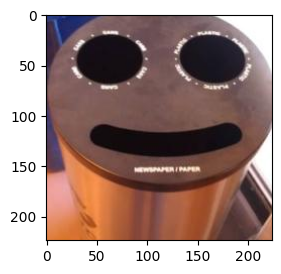

(224, 224, 3)


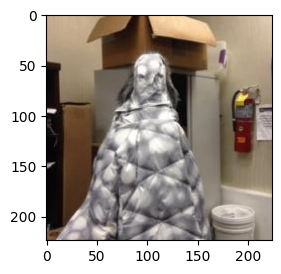

(224, 224, 3)


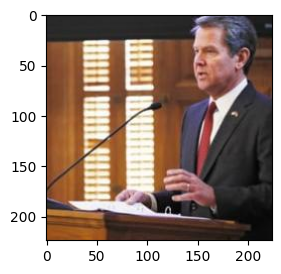

(224, 224, 3)


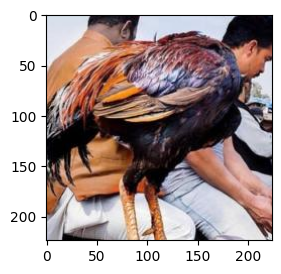

(224, 224, 3)


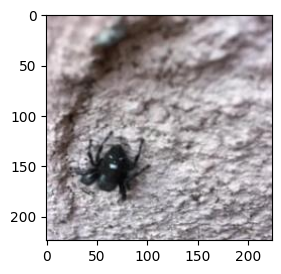

In [15]:
# test plot resized images
for i in range(5):
    path = '../data/images/' + df_clean['id'][i] + '.jpg'
    im = np.array(Image.open(path))

    print(im.shape)
    ax = plt.subplot(121)
    ax.imshow(im)
    plt.show()

#### Text Preprocessing

Dataset contains a clean_title column. The original text column was cleaned using the following steps:
* Remove all punctuation, numbers, words that reveal the subreddit source

* Converted all text to lowercase

Hence, we will not be repeating the above steps again.

In [34]:
# drop `title` column since we will use `clean_title` column
df_clean.drop(['title'], axis=1, inplace=True)

In [35]:
print(len(df_clean))
df_clean.head(5)

0


,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,upvote_ratio,3_way_label


In [18]:
# save clean file
df_clean.to_csv('../data/fakeddit_clean.tsv', sep='\t', index=False)

In [3]:
# load clean data
fakeddit_clean = pd.read_csv('../data/fakeddit_clean.tsv', sep='\t')

In [58]:
print(len(fakeddit_clean))
fakeddit_clean.head(5)

NameError: name 'fakeddit_clean' is not defined

In [ ]:
# tokenize titles for BERT and CLIP
def tokenize_titles(df, column_name='clean_title', max_length=256, device='cpu'):

    titles = df[column_name].astype(str).tolist()

    # use BERT tokenizer
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_encoded = bert_tokenizer(
        titles,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    # use CLIP tokenizer
    clip_model, _ = clip.load('ViT-B/32', device=device)
    clip_tokens = clip.tokenize(titles).to(device)

    return df, bert_encoded, clip_tokens

fakeddit_clean, bert_tokens, clip_tokens = tokenize_titles(fakeddit_clean)

train-validation-test split
preprocessing before splitting can cause the test set to implicitly learn from information in the training set, leading to an overly optimistic performance estimate. 

To shift up after discussing - to before tokenising and resizing pipeline
afterwards the datasets can be saved and renamed as train, validation, test(?)

In [60]:
# train-val-test split before tokenization & image transformation
# preprocessing before splitting can cause the test set to implicitly learn from information in the training set, leading to an overly optimistic performance estimate. 
# to shift up after discussing - to before resizing pipeline
from sklearn.utils.class_weight import compute_class_weight
# train-val-test split of 80-10-10
RANDOM_STATE = 42
train_df, temp_df = train_test_split(
    df_clean,
    test_size=0.20,
    shuffle=True,
    stratify=df_clean['3_way_label'],
    random_state=RANDOM_STATE
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    shuffle=True,
    stratify=temp_df['3_way_label'],
    random_state=RANDOM_STATE
)

print(f'Train size: {len(train_df)}')
print(f'Validation size: {len(val_df)}')
print(f'Test size: {len(test_df)}')

# checking class balance in splits
print("Label distribution (train):")
print(train_df["3_way_label"].value_counts(normalize=True))
print("Label distribution (validation):")
print(val_df["3_way_label"].value_counts(normalize=True))
print("Label distribution (test):")
print(test_df["3_way_label"].value_counts(normalize=True))

# class weighting: due to class imbalance
y_train = train_df['3_way_label']

classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print("Class weights:", class_weights)

# to use this as loss later
#criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


Train size: 30174
Validation size: 3772
Test size: 3772
Label distribution (train):
3_way_label
0    0.551634
2    0.412441
1    0.035925
Name: proportion, dtype: float64
Label distribution (validation):
3_way_label
0    0.551432
2    0.412513
1    0.036055
Name: proportion, dtype: float64
Label distribution (test):
3_way_label
0    0.551697
2    0.412513
1    0.035790
Name: proportion, dtype: float64
Class weights: tensor([0.6043, 9.2786, 0.8082])
